# Data affordances in Digital Humanities information visualisation practices — Reproducible Analysis

This notebook documents the analytical workflow conducted for the study presented in *Data affordances in Digital Humanities information visualisation practices*.
It provides an executable account of the steps used to evaluate how cultural-heritage datasets support visualisation and storytelling practices across 33 student projects produced between 2021 and 2025 at the University of Bologna.

The notebook reproduces the full data-processing pipeline used in the paper:
- parsing the project corpus,
- annotating text and chart components,
- computing the four proposed metrics—Interaction Level (IL), Creator Complexity Index (CCI), Exploratory Score (EDS), and Explanatory Score (XPS), and
- generating the descriptive and inferential analyses reported in the study.

Two companion datasets are included:
- **website_structure.csv**, containing the structured representation of narrative and visual elements for each project;
- **records.csv*, containing chart-level annotations, metadata, and metric components.

Together, this notebook and the datasets ensure full reproducibility of the results. They allow readers to inspect each analytical step, regenerate the figures used in the publication, and extend the methodology to other collections of data-driven visualisation projects.

In [55]:
import os
import pprint

from itertools import combinations
from collections import Counter

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from matplotlib.ticker import PercentFormatter

In [2]:
def read_records(path: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(path, encoding="utf-8-sig")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="utf-8")


def split_explode(series: pd.Series) -> pd.Series:
    s = series.fillna("").astype(str)
    s = s.str.split(";")
    s = s.explode()
    s = s.str.strip()
    s = s[s != ""]
    return s

In [3]:
path = Path("records.csv")
df = read_records(path)

people_col = "people" if "people" in df.columns else None
src_col = "data_source" if "data_source" in df.columns else None

print("Columns:", list(df.columns))
print("Rows:", len(df))

ppl = split_explode(df[people_col]).str.upper()
print("\nPeople (token counts):")
print(ppl.value_counts())

print("\nPeople (per-row totals):")
ppl_counts = split_explode(df[people_col]).groupby(level=0).size()
print(ppl_counts.describe())

Columns: ['course_end', 'exam', 'notebook', 'people', 'repository', 'website', 'website_structure_count', 'data_source']
Rows: 33

People (token counts):
people
F    59
M    18
Name: count, dtype: int64

People (per-row totals):
count    33.000000
mean      2.333333
std       0.889757
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: people, dtype: float64


In [4]:
src = split_explode(df[src_col])
print("\nSources (token counts):")
print(src.value_counts())


Sources (token counts):
data_source
Wikidata                                                 18
Zeri Photo Archive Collection                             5
ARTchives                                                 5
IMDb                                                      3
MoMA(Museum of Modern Art)                                2
Wikipedia                                                 2
ACNP(Archivio collettivo nazionale dei periodici)         1
CIRCE(Catalogo Informatico Riviste Culturali Europee)     1
Google Books API                                          1
Web Gallery of Art                                        1
Luoghi della cultura                                      1
de Kooning Foundation                                     1
SJR(Scimago Journal Rank)                                 1
Scopus                                                    1
Iconology Dataset                                         1
Camera dei deputati                                       1
Kun

In [5]:
def count_sources(cell):
    if pd.isna(cell):
        return 0
    return sum(1 for part in str(cell).split(';') if part.strip())

df['data_source_count'] = df[src_col].apply(count_sources)
counts = df[['website', src_col, 'data_source_count']].sort_values('data_source_count', ascending=False)
display(counts)
print('Mean sources per project:', df['data_source_count'].mean().round(2))
print('Median:', df['data_source_count'].median())
print('Max:', df['data_source_count'].max())


,website,data_source,data_source_count
4,https://giorgiacrosilla.github.io/reputationera/,de Kooning Foundation;Blouin Art Sales Index;B...,4
32,https://digitalstory33.github.io/RENAIScience/...,ARTchives;Wikidata;SNAC(Social Networks and Ar...,4
18,https://giuliavenditti.github.io/Streamingocracy/,Netflix;Amazon Prime;Wikidata;IMDb,4
17,https://fran-cesca.github.io/ArtCut.github.io/,MoMA(Museum of Modern Art);Tate Gallery;Wikidata,3
1,https://nicoleliggeri.github.io/Italy-in-Magaz...,CIRCE(Catalogo Informatico Riviste Culturali E...,3
8,https://giorgimariachiara.github.io/COD/index....,Camera dei deputati;Wikidata;Wikipedia,3
20,https://alicebordignon.github.io/ITArtHistoria...,Dictionary of Art Historians;ARTchives;Wikidata,3
23,https://laurentfintoni.github.io/Net-Art-Rev/,MoMA(Museum of Modern Art);Rhizome ArtBase;ULAN,3
0,https://baizhankyzy.github.io/female-directors/,Wikidata;IMDb,2
16,https://madrigalis.github.io/index,British Library History of Printed Music;Wikidata,2


Mean sources per project: 1.97
Median: 2.0
Max: 4


,projects_using_type
chart_type,
bar,32
map,20
pie,18
card,14
line,13
doughnut,8
wordcloud,6
bubble,5
timeline,5


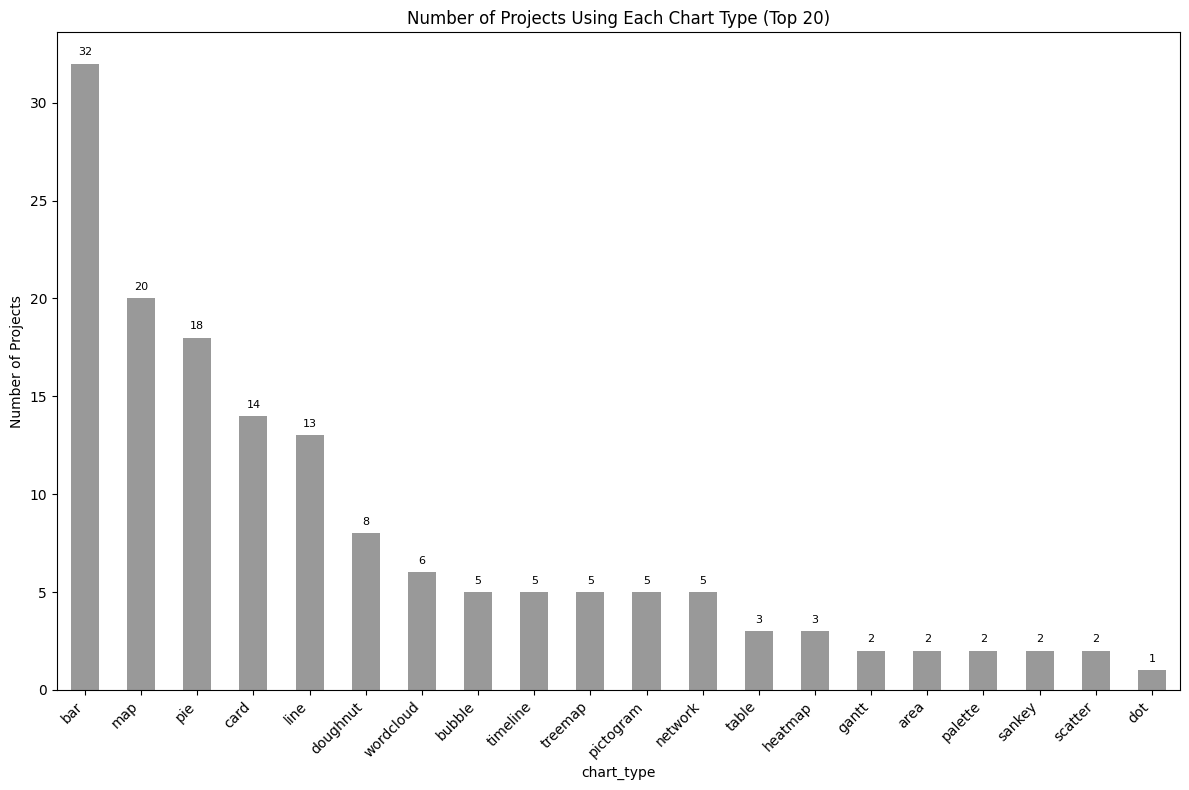

In [7]:
ws = pd.read_csv('website_structure.csv', encoding='utf-8-sig')

# Normalize chart_type
ws['chart_type'] = ws['chart_type'].dropna().astype(str).str.strip().str.lower()

# Group by chart_type and count distinct projects
chart_per_project = (
    ws.dropna(subset=['chart_type'])
      .groupby('chart_type')['record_index']
      .nunique()   # number of unique projects that use this chart type
      .sort_values(ascending=False)
)

# Display the data
display(chart_per_project.to_frame(name='projects_using_type'))

# Plot the top 20 chart types by number of projects
topN = chart_per_project.head(20)
ax = topN.plot(
    kind='bar',
    figsize=(12, 8),
    color='#999999'
)

# Add chart title and labels
ax.set_title('Number of Projects Using Each Chart Type (Top 20)')
ax.set_xlabel('chart_type')
ax.set_ylabel('Number of Projects')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add count labels above each bar
for i, v in enumerate(topN.values):
    ax.text(i, v + max(topN.values)*0.01, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
# Save and show the chart
plt.show()


In [ ]:
ws = read_records(Path("website_structure.csv"))
# Keep ONLY chart rows
# Mask for chart rows (we'll apply all logic only on these rows)
m_chart = ws["type"].astype(str).str.strip().str.lower().eq("chart section")

# --- Normalize ONLY chart rows safely ---
# Always use .loc[mask, col] so non-chart rows stay untouched
ws.loc[m_chart, "chart_type"] = (
    ws.loc[m_chart, "chart_type"].fillna("").astype(str).str.strip().str.lower()
)
ws.loc[m_chart, "chart_design_feature"] = (
    ws.loc[m_chart, "chart_design_feature"].fillna("").astype(str).str.strip().str.lower()
)

# Standardize clusters → cluster (only chart rows)
ws.loc[m_chart, "chart_design_feature"] = (
    ws.loc[m_chart, "chart_design_feature"]
      .str.replace(";clusters", ";cluster", regex=False)
      .str.replace("^clusters$", "cluster", regex=True)
)

# --- Cleaned feature list per chart row ---
def _clean_feats(s: str) -> list:
    """Split on ';', strip tokens, and drop '(none)'/'comparison'."""
    parts = [t.strip() for t in s.split(";")] if isinstance(s, str) else []
    return [t for t in parts if t and t not in {"(none)", "comparison"}]

feats = ws.loc[m_chart, "chart_design_feature"].apply(_clean_feats)

# --- Build derived display label ONLY for chart rows ---
display_label = ws.loc[m_chart, "chart_type"].copy()

# 1) MAP: simple only 'pin'; any other feature => complex
is_map = display_label.eq("map")
map_feats = feats[is_map]
display_label.loc[is_map & map_feats.apply(lambda fs: len(fs) == 1 and fs[0] == "pin")] = "map_simple"
display_label.loc[is_map & map_feats.apply(lambda fs: not (len(fs) == 1 and fs[0] == "pin"))] = "map_complex"

# 2) CARD: rich if BOTH image & metadata
is_card = display_label.eq("card")
card_feats = feats[is_card]
display_label.loc[is_card & card_feats.apply(lambda fs: ("image" in fs) and ("metadata" in fs))] = "card_rich"
display_label.loc[is_card & ~(card_feats.apply(lambda fs: ("image" in fs) and ("metadata" in fs)))] = "card"

# 3) TIMELINE: any feature => rich
is_tl = display_label.eq("timeline")
tl_feats = feats[is_tl]
display_label.loc[is_tl & tl_feats.apply(lambda fs: len(fs) > 0)] = "timeline_rich"
display_label.loc[is_tl & ~(tl_feats.apply(lambda fs: len(fs) > 0))] = "timeline"

# 4) BAR: stacked > grouped > radial > diverging
is_bar = display_label.eq("bar")
bar_feats = feats[is_bar]
display_label.loc[is_bar & bar_feats.apply(lambda fs: "stack" in fs)] = "stacked bar"
display_label.loc[is_bar & bar_feats.apply(lambda fs: ("stack" not in fs) and ("multibar" in fs))] = "other"
display_label.loc[is_bar & bar_feats.apply(lambda fs: ("stack" not in fs) and ("multibar" not in fs) and ("radial" in fs))] = "other"
display_label.loc[is_bar & bar_feats.apply(lambda fs: ("stack" not in fs) and ("multibar" not in fs) and ("radial" not in fs) and ("diverging" in fs))] = "other"

# 5) LINE: promote to multiline
is_line = display_label.eq("line")
line_feats = feats[is_line]
display_label.loc[is_line & line_feats.apply(lambda fs: "multiline" in fs)] = "multiline line"

# 6) SCATTER/DOT: bubble > scatter (trendline)
is_scatter = display_label.isin(["scatter", "dot"])
sc_feats = feats[is_scatter]
display_label.loc[is_scatter & sc_feats.apply(lambda fs: "bubble" in fs)] = "bubble chart"
display_label.loc[is_scatter & sc_feats.apply(lambda fs: ("bubble" not in fs) and ("trendline" in fs))] = "scatter (trendline)"

# 7) PIE/DOUGHNUT: semi- variants
is_pie = display_label.isin(["pie", "doughnut"])
pd_feats = feats[is_pie]
display_label.loc[is_pie & ws.loc[m_chart, "chart_type"].eq("pie") & pd_feats.apply(lambda fs: "semi" in fs)] = "semi-pie"
display_label.loc[is_pie & ws.loc[m_chart, "chart_type"].eq("doughnut") & pd_feats.apply(lambda fs: "semi" in fs)] = "semi-doughnut"

# --- Attach the derived label back to the FULL dataframe ---
# Initialize column (keeps NaN for non-chart rows)
ws["chart_type_derived"] = pd.NA
# Fill only where we computed it
ws.loc[m_chart, "chart_type_derived"] = display_label

# # === SAVE: full dataset preserved ===
# out_path = Path("website_structure_with_interactions_derived.csv")
# ws.to_csv(out_path, index=False, encoding="utf-8-sig")
# print(f"[✓] Saved with derived types (full dataset preserved) -> {out_path}")

# --- Plot counts using only chart rows (same as before) ---
counts = display_label.value_counts()
derived_types = sorted(display_label.dropna().astype(str).str.strip().unique())
print(derived_types)



['area', 'bar', 'bubble', 'card', 'card_rich', 'chart-report', 'chord', 'dot', 'doughnut', 'dumbell', 'gantt', 'heatmap', 'hemicycle', 'line', 'map_complex', 'map_simple', 'matrix', 'multiline line', 'network', 'other', 'palette', 'pictogram', 'pie', 'radar', 'sankey', 'scatter', 'semi-doughnut', 'semi-pie', 'stacked bar', 'table', 'timeline', 'timeline_rich', 'treemap', 'wordcloud']


C:\Users\giuli\AppData\Local\Temp\ipykernel_21916\1288686480.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Greys')


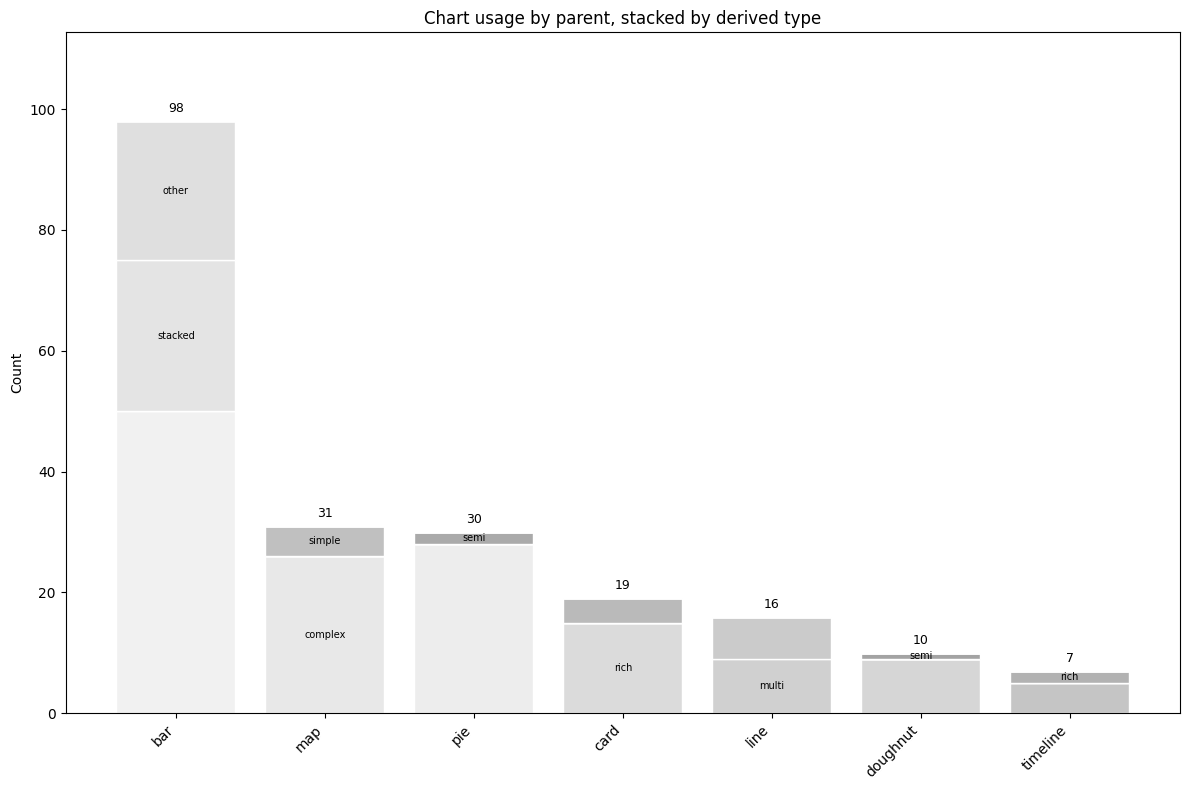

In [13]:
def simple_reduce(derived, parent):
    d = derived.lower().strip()
    p = parent.lower().strip()

    # remove the parent name wherever it appears
    d = d.replace(p, "").strip()

    # remove separators left behind
    d = d.replace("_", "").replace("-", "").strip()

    return d


# === BUILD: parent (original chart_type) vs derived (display_label) ===
# We'll only use CHART rows, and keep the original, normalized parent type.
parent = ws.loc[m_chart, "chart_type"].copy()                # parent category
derived = display_label.copy()                                # derived sub-type used as stacks

# Make a pivot table of counts: rows=parent, cols=derived
pivot = (
    pd.crosstab(parent, derived)
      .sort_index()  # initial deterministic order
)

# ---------------------------------------------------------
# Filter out parents that are just "simple" (or single-type)
# ---------------------------------------------------------
# We count how many columns have a count > 0 for each parent
types_per_parent = (pivot > 0).sum(axis=1)

# Keep only rows where the count of types is strictly greater than 1
pivot = pivot.loc[types_per_parent > 1]
# ---------------------------------------------------------

# Reorder rows by total frequency ---
row_totals = pivot.sum(axis=1).sort_values(ascending=False)

# To drop parents that have zero derived labels
pivot = pivot.loc[pivot.sum(axis=1) > 0]

# Reorder rows by total frequency (largest on top of the chart) ---
row_totals = pivot.sum(axis=1).sort_values(ascending=False)
pivot = pivot.loc[row_totals.index]

# Reorder columns (stacks) by global frequency for a consistent legend order ---
col_totals = pivot.sum(axis=0).sort_values(ascending=False)
pivot = pivot[col_totals.index]

# === PLOT: stacked horizontal bars per parent ===
os.makedirs("imgs", exist_ok=True)

fig, ax = plt.subplots(figsize=(12, 8))

# We’ll draw stacks column-by-column using cumulative left offsets.
x_positions = range(len(pivot.index)) # Categories are now on X-axis
bottom = pd.Series([0]*len(pivot.index), index=pivot.index)  # running offset per row

# Choose a deterministic list of labels for the legend
stack_labels = list(pivot.columns)

def gray_palette(n):
    # From near-black to near-white, perceptually spaced
    base = ['#111111', '#2b2b2b', '#444444', '#5e5e5e',
            '#777777', '#919191', '#ababab', '#c5c5c5', '#dddddd', '#f0f0f0']
    if n <= len(base):
        return base[:n]
    cmap = mpl.cm.get_cmap('Greys')
    # 0=black, 1=white; keep a wide span for contrast
    return [mpl.colors.to_hex(cmap(v)) for v in np.linspace(0.12, 0.92, n)]

num_stacks = len(stack_labels)
gray_colors = gray_palette(num_stacks)

for col, color in zip(stack_labels, gray_colors):
    values = pivot[col].values
    ax.bar(
        pivot.index,
        values,
        bottom=bottom[pivot.index].values,
        label=col,
        color=color,
        edgecolor="white"
    )
    bottom[pivot.index] = bottom[pivot.index] + pivot[col]


# Add value labels for each segment (only if non-zero)
# (Keeps the chart readable for moderate-sized datasets.)
# --- Label segments with derived-type name ONLY when the bar is truly stacked ---

# Precompute how many derived sub-types each parent has
segments_per_parent = (pivot > 0).sum(axis=1)

for i, parent_label in enumerate(pivot.index):

    # skip non-stacked bars
    if segments_per_parent[parent_label] <= 1:
        continue

    cumulative = 0
    for col in stack_labels:
        v = pivot.loc[parent_label, col]
        if v > 0:
            short = simple_reduce(col, parent_label)

            # only draw if something remains
            if short:
                ax.text(
                    i,
                    cumulative + v/2,
                    short,
                    ha="center",
                    va="center",
                    fontsize=7
                )

            cumulative += v


# Add total labels at the right side of each bar
totals = pivot.sum(axis=1)
y_pad = max(totals.max() * 0.01, 0.5)
max_total = totals.max()
ax.set_ylim(0, max_total * 1.15)
for x, total in enumerate(totals.values):
    ax.text(x, total + y_pad, str(total), va="bottom", ha="center", fontsize=9)

ax.set_title("Chart usage by parent, stacked by derived type")
ax.set_ylabel("Count")
ax.set_xlabel("")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


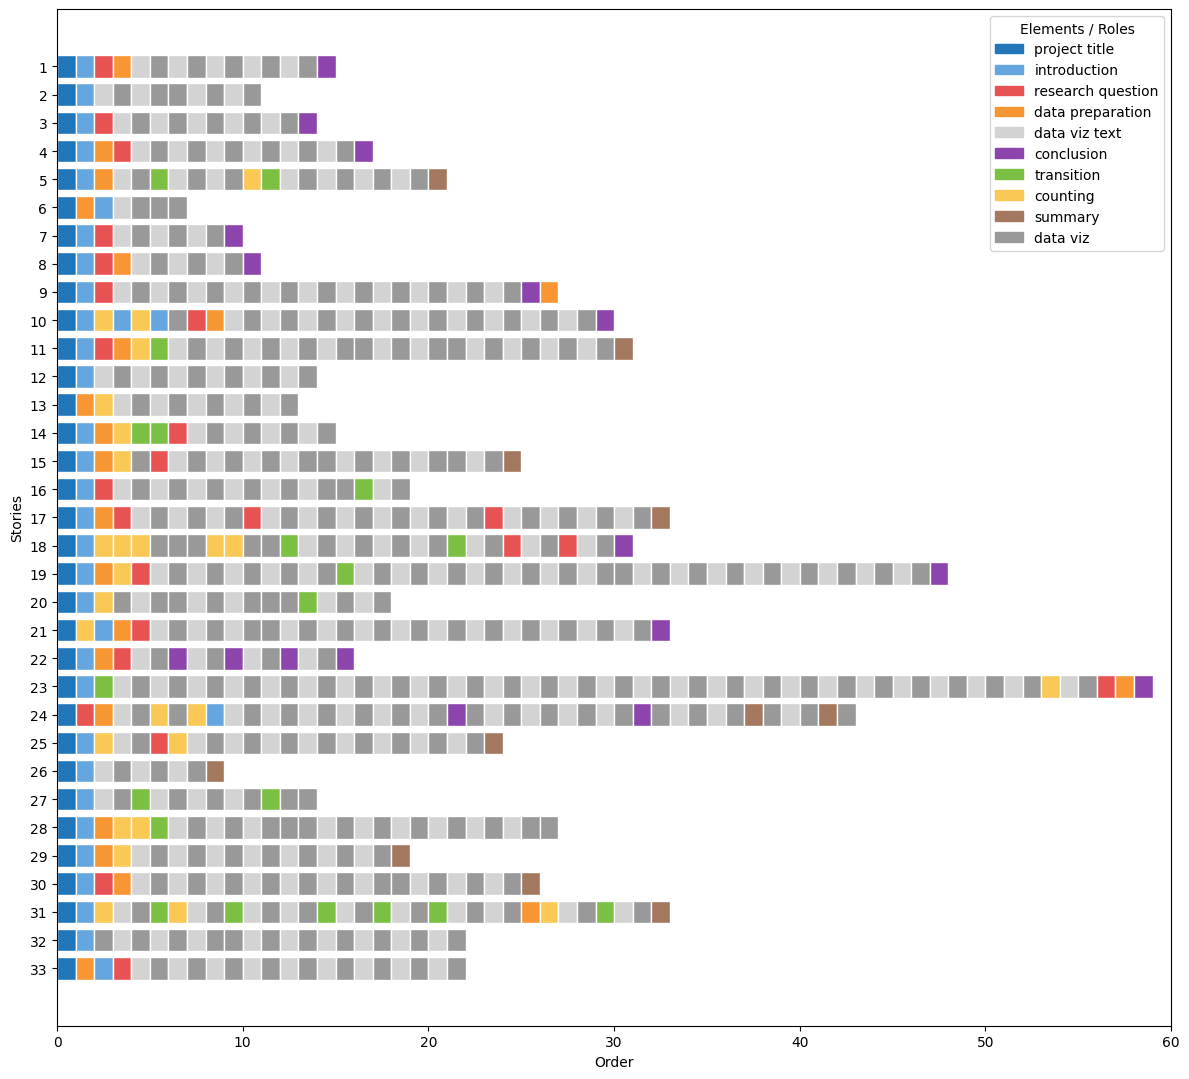

In [15]:
ws = pd.read_csv('website_structure.csv', encoding='utf-8-sig')

CHART_CONTENT_LABEL = 'data viz text'  # <--- label we assign to chart text with NaN role

def row_to_elements(row):
    """
    Convert a row into (element, role) pairs:
      - ('text', <role_from_role_col>) for rows where type == 'text'
      - ('text', CHART_CONTENT_LABEL) for chart_section text content (role is NaN by design)
      - ('data viz', None) for the visualization block
    """
    t = str(row.get('type', '') or '').strip().lower()
    role_raw = str(row.get('role', '') or '').strip().lower()
    has_chart = pd.notna(row.get('chart_type')) and str(row.get('chart_type')).strip() != ''
    has_content = pd.notna(row.get('content')) and str(row.get('content')).strip() != ''

    elements = []

    if t == 'text':
        # Text rows: use the provided role (fallback to a neutral label if empty)
        role = role_raw if role_raw else 'text_unlabeled'
        elements.append(('text', role))

    elif t == 'chart_section':
        # Chart rows:
        # 1) If there is text content tied to the chart, label it as chart_content
        if has_content:
            elements.append(('text', CHART_CONTENT_LABEL))
        # 2) Then the chart block itself
        if has_chart:
            elements.append(('data viz', None))

    else:
        # Any other row type with content but no chart -> treat as text (rare)
        if has_content and not has_chart:
            role = role_raw if role_raw else 'text_unlabeled'
            elements.append(('text', role))
        elif has_chart:
            if has_content:
                elements.append(('text', CHART_CONTENT_LABEL))
            elements.append(('data viz', None))

    return elements


# Build ordered element sequences per record_index
seq_rows = []
for rid, grp in ws.groupby('record_index', sort=False):
    for _, r in grp.iterrows():
        for e, role in row_to_elements(r):
            seq_rows.append({'record_index': rid, 'element': e, 'role': role})

seq = pd.DataFrame(seq_rows)

if seq.empty:
    print('No elements detected to plot.')
else:
    seq['order'] = seq.groupby('record_index').cumcount() + 1

    # --- Palette setup ---
    palette = {'data viz': '#999999'}  # fixed gray for charts

    role_colors = {
        'project title': '#2076B9',
        'introduction': '#65A6DE',
        'research question': '#E75252',
        'data preparation': '#F79632',
        'counting': '#F9C855',
        'transition': '#7BC043',
        'conclusion': '#8E44AD',
        'summary': '#A3785E',
        CHART_CONTENT_LABEL: '#D3D3D3',  # <--- color for chart-related text content (role was NaN)
    }

    def color_for_row(row):
        if row['element'] == 'data viz':
            return palette['data viz']
        return role_colors.get(row['role'], '#999999')

    # --- Plot ---
    groups = list(seq.groupby('record_index', sort=False))
    fig, ax = plt.subplots(figsize=(12, 0.3 * len(groups) + 1))

    for y, (rid, s) in enumerate(groups):
        for _, rr in s.iterrows():
            ax.barh(
                y,
                1,
                left=int(rr['order']) - 1,
                color=color_for_row(rr),
                edgecolor='white',
                height=0.8
            )

    ax.set_yticks(range(len(groups)))
    ax.set_yticklabels([str(rid) for rid, _ in groups])
    ax.set_xlabel('Order')
    ax.set_ylabel('Stories')
    ax.invert_yaxis()
    ax.set_xlim(0, int(seq['order'].max()) + 1)

    # Legend: roles actually used + 'data viz'
    used_roles = list(dict.fromkeys(seq.loc[seq['element'] == 'text', 'role']))
    handles = [mpatches.Patch(color=role_colors.get(r, '#999999'), label=r) for r in used_roles]
    handles.append(mpatches.Patch(color=palette['data viz'], label='data viz'))

    ax.legend(handles=handles, title='Elements / Roles', loc='upper right', ncol=1)
    plt.tight_layout()
    plt.show()


## Interaction Level (IL)

In [36]:
df = pd.read_csv('website_structure.csv', encoding='utf-8') # or 'utf-8-sig'
print(df.head())

   record_index                                          website  \
0             1  https://baizhankyzy.github.io/female-directors/   
1             1  https://baizhankyzy.github.io/female-directors/   
2             1  https://baizhankyzy.github.io/female-directors/   
3             1  https://baizhankyzy.github.io/female-directors/   
4             1  https://baizhankyzy.github.io/female-directors/   

            type               role chart_type chart_design_feature  \
0           text      project title        NaN                  NaN   
1           text       introduction        NaN                  NaN   
2           text  research question        NaN                  NaN   
3           text   data preparation        NaN                  NaN   
4  chart section                NaN       line                  NaN   

  chart_interaction_feature  \
0                       NaN   
1                       NaN   
2                       NaN   
3                       NaN   
4        

In [37]:
features = set()
for feature_list in df['chart_interaction_feature']:
    if pd.notna(feature_list):
        for feature in feature_list.split(';'):
            features.add(feature.strip())
print(len(features), "unique features found:")
pprint.pp(features)

18 unique features found:
{'animation',
 'broken-y',
 'carousel',
 'click',
 'filters',
 'find-more',
 'flip',
 'hover',
 'link',
 'metadata',
 'on-demand',
 'pagination',
 'quiz',
 'scrollytelling',
 'search',
 'time-animation',
 'view-change',
 'zoom'}


In [38]:
# --- Config ------------------------------------------------------------------
ALIASES = {
    "find-more": "search",
    "find_more": "search",
    "filter": "filters",           # normalize singular → plural
    "time_animation": "time-animation",
}

FAMILIES = {
    "basic": {"click", "hover", "link", "flip"},
    "exploration": {"filters", "search", "zoom"},
    "navigation": {"pagination", "view-change"},
    "analytical": {"broken-y"},
    "on_demand": {"metadata", "on-demand"},
    "storytelling": {"scrollytelling", "animation", "time-animation", "carousel", "quiz"},
}

FAMILY_WEIGHT = {
    "basic": 1,
    "exploration": 2,
    "navigation": 2,
    "analytical": 2,
    "on_demand": 3,
    "storytelling": 3,
}

# --- Helpers -----------------------------------------------------------------
import re

def normalize_token(tok: str) -> str:
    """Lowercase, unify dashes/underscores, apply aliases."""
    tok = (tok or "").strip().lower()
    tok = tok.replace("_", "-")                # treat '_' and '-' the same
    tok = ALIASES.get(tok, tok)                # map known variants
    return tok

def split_tokens(value):
    """Split an interaction feature *string* or list into normalized tokens."""
    if isinstance(value, list):
        return [normalize_token(t) for t in value]
    if not isinstance(value, str):
        return []
    # split on commas, pipes, semicolons, or whitespace
    raw = re.split(r"[,\|\;]\s*|\s+", value)
    return [normalize_token(t) for t in raw if t]

def interaction_level_capped(value) -> int:
    """
    Return the MAX family weight present in the tokens (0 if none recognized).
    """
    toks = split_tokens(value)
    max_level = 0
    for tok in toks:
        for fam, keywords in FAMILIES.items():
            if tok in keywords:
                lvl = FAMILY_WEIGHT[fam]
                if lvl > max_level:
                    max_level = lvl
    return max_level

# --- Apply to the *column*, not the whole row) ---
INTERACTION_COL = "chart_interaction_feature" 

df["interaction_level"] = df[INTERACTION_COL].apply(interaction_level_capped)

print("Added interaction_level. Sample:")
print(df[["chart_type", INTERACTION_COL, "interaction_level"]].head(10))

out_path = "website_structure_with_interactions.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")


Added interaction_level. Sample:
  chart_type chart_interaction_feature  interaction_level
0        NaN                       NaN                  0
1        NaN                       NaN                  0
2        NaN                       NaN                  0
3        NaN                       NaN                  0
4       line                       NaN                  0
5        bar                       NaN                  0
6        map                      zoom                  2
7   doughnut                       NaN                  0
8        bar                       NaN                  0
9        NaN                       NaN                  0


In [39]:
# chart type x interaction level

ws = pd.read_csv('website_structure_with_interactions.csv', encoding='utf-8-sig')

# Filter only rows that actually represent charts (non-null chart_type)
charts_df = ws[ws["chart_type"].notna()].copy()

# Count number of data sources per chart
# Split data_source by ';' and count items
num_sources = []
for value in charts_df["data_source"]:
    if pd.isna(value):
        print('Missing')
    parts = value.split(";")
    cleaned = []
    for part in parts:
        stripped = part.strip()
        if stripped:
            cleaned.append(stripped)
    num_sources.append(len(cleaned))

charts_df["num_data_sources"] = num_sources

# Keep only the relevant columns for analysis
chart_analysis_df = charts_df[[
    "website", "chart_type", "interaction_level", "num_data_sources"
]]



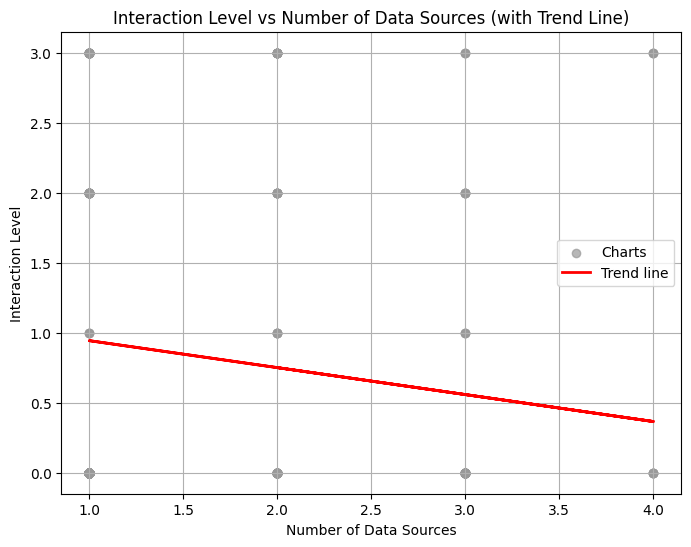

Pearson r   = -0.138 (p=0.01671987440725165)
Spearman ρ  = -0.138 (p=0.016170555168287422)
Kendall τ   = -0.126 (p=0.015544505804999838)


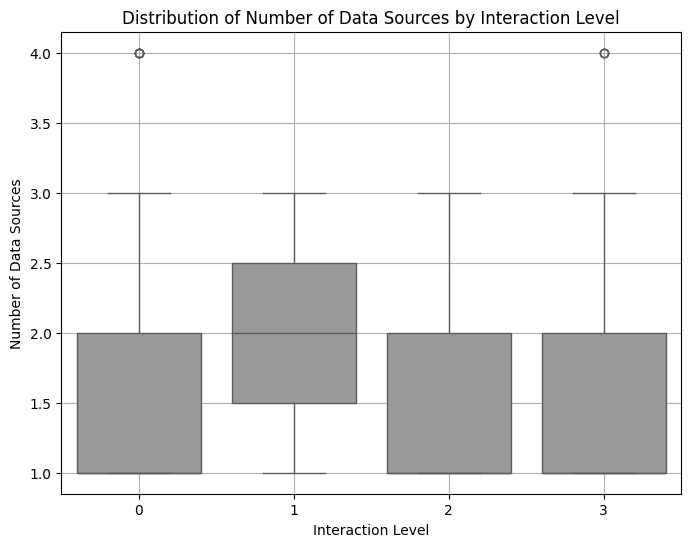

In [40]:
# --- 1. Scatter plot ---
plt.figure(figsize=(8, 6))

# Scatter points
plt.scatter(
    chart_analysis_df["num_data_sources"], 
    chart_analysis_df["interaction_level"], 
    alpha=0.7, label="Charts",
    color="#999999"
)

# Compute and plot regression line (linear fit)
x = chart_analysis_df["num_data_sources"]
y = chart_analysis_df["interaction_level"]
m, b = np.polyfit(x, y, 1)  # linear regression (slope, intercept)
plt.plot(x, m*x + b, color="red", linewidth=2, label="Trend line")

# Labels and aesthetics
plt.title("Interaction Level vs Number of Data Sources (with Trend Line)")
plt.xlabel("Number of Data Sources")
plt.ylabel("Interaction Level")
plt.grid(True)
plt.legend()
plt.show()

# --- 2. Correlation analysis ---
# Compute Pearson and Spearman correlations
pearson_corr, pearson_p = pearsonr(
    chart_analysis_df["num_data_sources"], chart_analysis_df["interaction_level"]
)
spearman_corr, spearman_p = spearmanr(
    chart_analysis_df["num_data_sources"], chart_analysis_df["interaction_level"]
)

kendall_corr, kendall_p = kendalltau(
    chart_analysis_df["num_data_sources"], chart_analysis_df["interaction_level"]
)


# Return correlation results
print(f"Pearson r   = {pearson_corr:.3f} (p={pearson_p})")
print(f"Spearman ρ  = {spearman_corr:.3f} (p={spearman_p})")
print(f"Kendall τ   = {kendall_corr:.3f} (p={kendall_p})")

# --- 3. Boxplot ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=chart_analysis_df, x="interaction_level", y="num_data_sources", color="#999999")
plt.title("Distribution of Number of Data Sources by Interaction Level")
plt.xlabel("Interaction Level")
plt.ylabel("Number of Data Sources")
plt.grid(True)
plt.show()


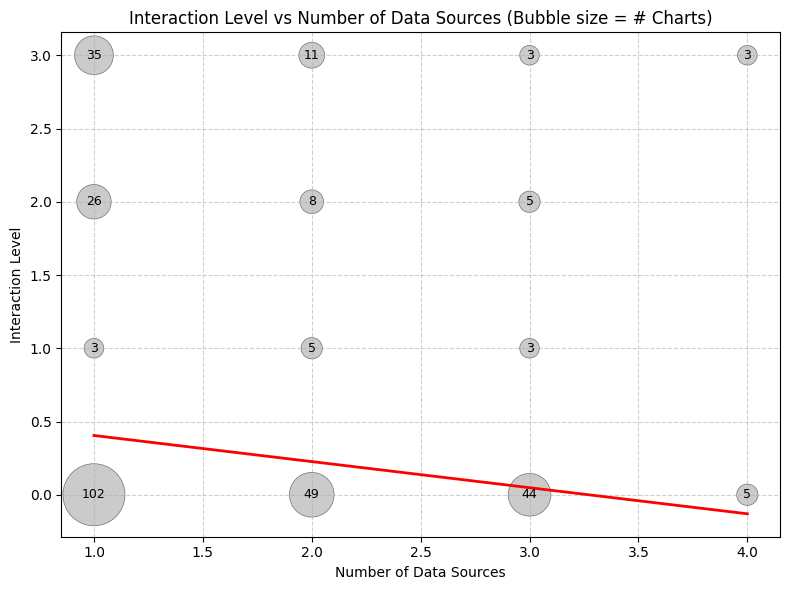

In [41]:
# --- Bubble chart: Interaction Level vs Number of Data Sources ---
agg = (
    chart_analysis_df
      .assign(
          num_data_sources=lambda d: pd.to_numeric(d['num_data_sources'], errors='coerce'),
          interaction_level=lambda d: pd.to_numeric(d['interaction_level'], errors='coerce')
      )
      .dropna(subset=['num_data_sources', 'interaction_level'])
      .groupby(['num_data_sources', 'interaction_level'], as_index=False)
      .agg(n_charts=('num_data_sources', 'size'))  # <-- count charts
)

# Map counts to bubble sizes
min_size, max_size = 200, 2000
if agg['n_charts'].max() == agg['n_charts'].min():
    sizes = np.full(len(agg), 600)
else:
    sizes = min_size + (agg['n_charts'] - agg['n_charts'].min()) / \
            (agg['n_charts'].max() - agg['n_charts'].min()) * (max_size - min_size)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(
    agg['num_data_sources'],
    agg['interaction_level'],
    s=sizes,
    alpha=0.5,
    edgecolors='black',
    linewidths=0.5,
    color='#999999'
)

# Add the number of charts inside each bubble
for _, row in agg.iterrows():
    plt.text(
        row['num_data_sources'],
        row['interaction_level'],
        str(int(row['n_charts'])),
        ha='center', va='center',
        fontsize=9
    )

# Weighted trend line (weighted by number of charts)
x = agg['num_data_sources'].to_numpy()
y = agg['interaction_level'].to_numpy()
w = agg['n_charts'].to_numpy()
try:
    m, b = np.polyfit(x, y, 1, w=w)
except TypeError:
    reps = np.clip(w.astype(int), 1, 100)
    x_rep = np.repeat(x, reps)
    y_rep = np.repeat(y, reps)
    m, b = np.polyfit(x_rep, y_rep, 1)

x_line = np.linspace(x.min(), x.max(), 100)
plt.plot(x_line, m*x_line + b, color='red', linewidth=2)

plt.title("Interaction Level vs Number of Data Sources (Bubble size = # Charts)")
plt.xlabel("Number of Data Sources")
plt.ylabel("Interaction Level")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
# Save and show the chart
plt.show()


## Creating the final file

In [42]:
# running this again to avoid having general 'other' labels from before
ws = read_records(Path("website_structure_with_interactions.csv"))
# Keep ONLY chart rows
# Mask for chart rows (we'll apply all logic only on these rows)
m_chart = ws["type"].astype(str).str.strip().str.lower().eq("chart section")

# --- Normalize ONLY chart rows safely ---
# Always use .loc[mask, col] so non-chart rows stay untouched
ws.loc[m_chart, "chart_type"] = (
    ws.loc[m_chart, "chart_type"].fillna("").astype(str).str.strip().str.lower()
)
ws.loc[m_chart, "chart_design_feature"] = (
    ws.loc[m_chart, "chart_design_feature"].fillna("").astype(str).str.strip().str.lower()
)

# Standardize clusters → cluster (only chart rows)
ws.loc[m_chart, "chart_design_feature"] = (
    ws.loc[m_chart, "chart_design_feature"]
      .str.replace(";clusters", ";cluster", regex=False)
      .str.replace("^clusters$", "cluster", regex=True)
)

# --- Cleaned feature list per chart row ---
def _clean_feats(s: str) -> list:
    """Split on ';', strip tokens, and drop '(none)'/'comparison'."""
    parts = [t.strip() for t in s.split(";")] if isinstance(s, str) else []
    return [t for t in parts if t and t not in {"(none)", "comparison"}]

feats = ws.loc[m_chart, "chart_design_feature"].apply(_clean_feats)

# --- Build derived display label ONLY for chart rows ---
display_label = ws.loc[m_chart, "chart_type"].copy()

# 1) MAP: simple only 'pin'; any other feature => complex
is_map = display_label.eq("map")
map_feats = feats[is_map]
display_label.loc[is_map & map_feats.apply(lambda fs: len(fs) == 1 and fs[0] == "pin")] = "map_simple"
display_label.loc[is_map & map_feats.apply(lambda fs: not (len(fs) == 1 and fs[0] == "pin"))] = "map_complex"

# 2) CARD: rich if BOTH image & metadata
is_card = display_label.eq("card")
card_feats = feats[is_card]
display_label.loc[is_card & card_feats.apply(lambda fs: ("image" in fs) and ("metadata" in fs))] = "card_rich"
display_label.loc[is_card & ~(card_feats.apply(lambda fs: ("image" in fs) and ("metadata" in fs)))] = "card"

# 3) TIMELINE: any feature => rich
is_tl = display_label.eq("timeline")
tl_feats = feats[is_tl]
display_label.loc[is_tl & tl_feats.apply(lambda fs: len(fs) > 0)] = "timeline_rich"
display_label.loc[is_tl & ~(tl_feats.apply(lambda fs: len(fs) > 0))] = "timeline"

# 4) BAR: stacked > grouped > radial > diverging
is_bar = display_label.eq("bar")
bar_feats = feats[is_bar]
display_label.loc[is_bar & bar_feats.apply(lambda fs: "stack" in fs)] = "stacked bar"
display_label.loc[is_bar & bar_feats.apply(lambda fs: ("stack" not in fs) and ("multibar" in fs))] = "grouped bar"
display_label.loc[is_bar & bar_feats.apply(lambda fs: ("stack" not in fs) and ("multibar" not in fs) and ("radial" in fs))] = "radial bar"
display_label.loc[is_bar & bar_feats.apply(lambda fs: ("stack" not in fs) and ("multibar" not in fs) and ("radial" not in fs) and ("diverging" in fs))] = "diverging bar"

# 5) LINE: promote to multiline
is_line = display_label.eq("line")
line_feats = feats[is_line]
display_label.loc[is_line & line_feats.apply(lambda fs: "multiline" in fs)] = "multiline line"

# 6) SCATTER/DOT: bubble > scatter (trendline)
is_scatter = display_label.isin(["scatter", "dot"])
sc_feats = feats[is_scatter]
display_label.loc[is_scatter & sc_feats.apply(lambda fs: "bubble" in fs)] = "bubble chart"
display_label.loc[is_scatter & sc_feats.apply(lambda fs: ("bubble" not in fs) and ("trendline" in fs))] = "scatter (trendline)"

# 7) PIE/DOUGHNUT: semi- variants
is_pie = display_label.isin(["pie", "doughnut"])
pd_feats = feats[is_pie]
display_label.loc[is_pie & ws.loc[m_chart, "chart_type"].eq("pie") & pd_feats.apply(lambda fs: "semi" in fs)] = "semi-pie"
display_label.loc[is_pie & ws.loc[m_chart, "chart_type"].eq("doughnut") & pd_feats.apply(lambda fs: "semi" in fs)] = "semi-doughnut"

# --- Attach the derived label back to the FULL dataframe ---
# Initialize column (keeps NaN for non-chart rows)
ws["chart_type_derived"] = pd.NA
# Fill only where we computed it
ws.loc[m_chart, "chart_type_derived"] = display_label

# === SAVE: full dataset preserved ===
out_path = Path("website_structure_with_interactions_derived.csv")
ws.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"Saved with derived types (full dataset preserved) -> {out_path}")

# --- Plot counts using only chart rows (same as before) ---
counts = display_label.value_counts()
derived_types = sorted(display_label.dropna().astype(str).str.strip().unique())
print(derived_types)



Saved with derived types (full dataset preserved) -> website_structure_with_interactions_derived.csv
['area', 'bar', 'bubble', 'card', 'card_rich', 'chart-report', 'chord', 'diverging bar', 'dot', 'doughnut', 'dumbell', 'gantt', 'grouped bar', 'heatmap', 'hemicycle', 'line', 'map_complex', 'map_simple', 'matrix', 'multiline line', 'network', 'palette', 'pictogram', 'pie', 'radar', 'radial bar', 'sankey', 'scatter', 'semi-doughnut', 'semi-pie', 'stacked bar', 'table', 'timeline', 'timeline_rich', 'treemap', 'wordcloud']


## Creator Complexity Index (CCI)

In [43]:
df = pd.read_csv('website_structure_with_interactions_derived.csv', encoding='utf-8') # or 'utf-8-sig'
charts = df[df["type"] == "chart section"].copy()

CHART_TYPE = {

    # === T1 — Non-analytic / decorative ===
    'palette': 2,

    # === T2 — Simple analytic ===
    'table': 4,
    'card': 4,
    'pie': 4,
    'doughnut': 4,
    'semi-pie': 4,
    'semi-doughnut': 4,
    'bar': 4,
    'wordcloud': 4,

    # === T3 — Moderate analytic ===
    'area': 6,
    'line': 6, 
    'dot': 6,
    'pictogram': 6,
    'scatter': 6,
    'bubble': 6,
    'dumbell': 6,
    'radar': 6,

    # promoted variants
    'multiline line': 6,
    'grouped bar': 6,
    'radial bar': 6,
    'diverging bar': 6,
    'map_simple': 6,

    # === T4 — Structured / hierarchical / temporal ===
    'stacked bar': 8,
    'timeline': 8,
    'heatmap': 8,
    'matrix': 8,
    'treemap': 8,
    'gantt': 8,
    'hemicycle': 8,
    'chart-report': 8,

    # === T5 — High structural / relational / rich ===
    'network': 10,
    'chord': 10,
    'sankey': 10,
    'map_complex': 10,
    'timeline_rich': 10,

    # special case: richer than a card but not analytic
    'card_rich': 6
}


FEATURE_WEIGHT_EXTRA = {
    "comparison": 1.5,
    "trendline": 1.5,
    "correlation": 2.0
}


# === COMPUTE CCI ===
ccis = []
n_sources = []

for _, row in charts.iterrows():
    # --- base type (use derived if available) ---
    derived = str(row.get("chart_type_derived", "")).strip().lower()
    fallback = str(row.get("chart_type", "")).strip().lower()
    chart_key = derived if derived else fallback
    if chart_key in CHART_TYPE:
        base = CHART_TYPE[chart_key]
    else:
        print(f"[WARN] Unknown chart type: {chart_key}")
        base = None

    # --- design features (comparison / trendline / correlation, etc.) ---
    feat_str = str(row.get("chart_design_feature", "")).strip().lower()
    feat_tokens = {t.strip() for t in feat_str.split(";") if t.strip()}
    feature_score = sum(FEATURE_WEIGHT_EXTRA.get(t, 0) for t in feat_tokens)

    # --- interaction level (already computed) ---
    inter = row.get("interaction_level", 0)
    try:
        inter = float(inter)
    except Exception:
        inter = 0.0

    # --- annotations: binary bump if present ---
    ann = str(row.get("chart_annotations", "")).strip()
    ann_bonus = 0.5 if len(ann) > 0 else 0.0  # +0.5 if any annotation text

    # --- repetition penalty ---
    repetition = str(row.get("repetition", "")).strip().lower()
    multiplier = 0.7 if repetition == "yes" else 1.0

    # --- final complexity ---
    cci = (base + feature_score + inter + ann_bonus) * multiplier
    ccis.append(cci)

    # --- number of data sources (for correlation only) ---
    ds = str(row.get("data_source", "")).strip()
    n_ds = len([s for s in ds.split(";") if s.strip()]) if ds else 0
    n_sources.append(n_ds)

charts["creator_complexity"] = ccis
charts["n_data_sources"] = n_sources

# === SAVE CHART-LEVEL RESULTS ===
chart_out = "chart_complexity_no_datasource_boost.csv"
keep = [
    "record_index","website","type",
    "chart_type","chart_type_derived",
    "chart_design_feature","chart_interaction_feature","interaction_level",
    "repetition","chart_annotations","data_points","data_source",
    "n_data_sources","creator_complexity"
]
charts.loc[:, [c for c in keep if c in charts.columns]].to_csv(chart_out, index=False, encoding="utf-8-sig")
print(f"Saved chart-level file: {chart_out}")

# === AGGREGATE PER PROJECT ===
project_level = charts.groupby("record_index").agg(
    mean_creator_complexity=("creator_complexity","mean"),
    sum_creator_complexity=("creator_complexity","sum"),
    max_creator_complexity=("creator_complexity","max"),
    num_charts=("creator_complexity","size"),
    avg_n_data_sources=("n_data_sources","mean"),
    max_n_data_sources=("n_data_sources","max")
).reset_index()

proj_out = "project_complexity_no_datasource_boost.csv"
project_level.to_csv(proj_out, index=False, encoding="utf-8-sig")
print(f"Saved project-level file: {proj_out}")

# === QUICK SUMMARY ===
print("\n== Chart-level summary ==")
print(charts["creator_complexity"].describe())

print("\n== Project-level preview ==")
print(project_level.head())

# === OPTIONAL: quick correlation check ===
corr = charts[["creator_complexity","n_data_sources"]].corr().iloc[0,1]
print(f"\nCorrelation between CCI and number of data sources (chart-level): {corr:.3f}")


Saved chart-level file: chart_complexity_no_datasource_boost.csv
Saved project-level file: project_complexity_no_datasource_boost.csv

== Chart-level summary ==
count    302.000000
mean       6.990563
std        2.707263
min        2.500000
25%        4.550000
50%        6.500000
75%        8.500000
max       15.000000
Name: creator_complexity, dtype: float64

== Project-level preview ==
   record_index  mean_creator_complexity  sum_creator_complexity  \
0             1                 7.430000                   37.15   
1             2                 6.990000                   34.95   
2             3                 8.100000                   40.50   
3             4                 6.416667                   38.50   
4             5                 7.028571                   49.20   

   max_creator_complexity  num_charts  avg_n_data_sources  max_n_data_sources  
0                    12.5           5            2.000000                   2  
1                    13.5           5   

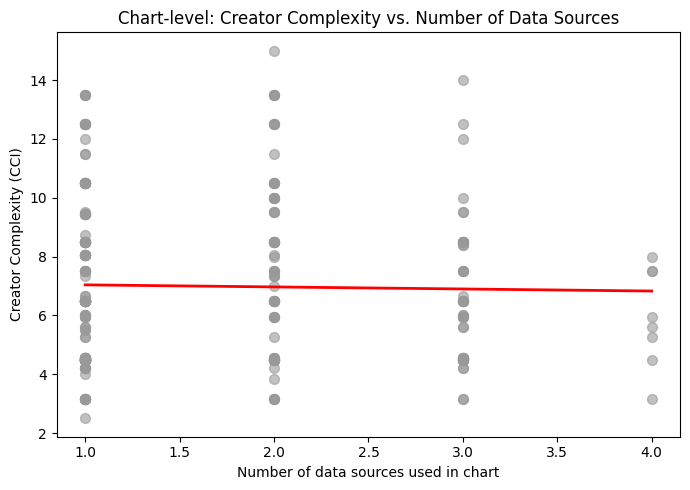

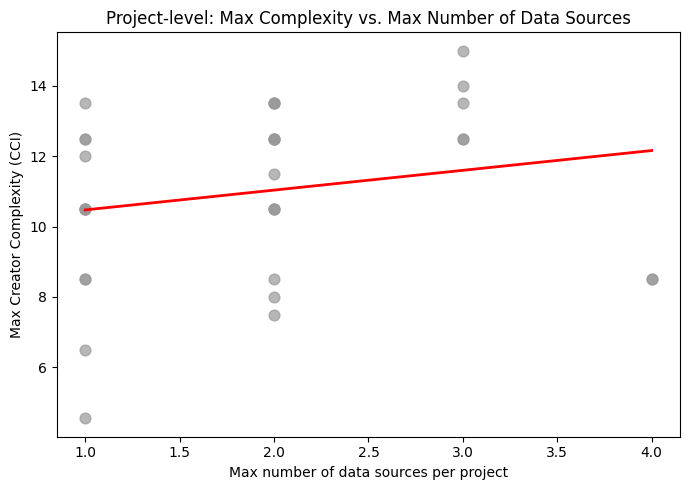

In [46]:
# === Load the datasets === 
charts = pd.read_csv("chart_complexity_no_datasource_boost.csv") 
projects = pd.read_csv("project_complexity_no_datasource_boost.csv")

# === SCATTERPLOT (chart-level) ===
x_c = charts["n_data_sources"]
y_c = charts["creator_complexity"]

plt.figure(figsize=(7,5))
plt.scatter(x_c, y_c, alpha=0.6, s=50, color="#999999")

# Regression line
m, b = np.polyfit(x_c, y_c, 1)
x_line = np.linspace(x_c.min(), x_c.max(), 100)
plt.plot(x_line, m*x_line + b, linewidth=2, color="red")

plt.title("Chart-level: Creator Complexity vs. Number of Data Sources")
plt.xlabel("Number of data sources used in chart")
plt.ylabel("Creator Complexity (CCI)")
plt.tight_layout()
plt.show()


# === SCATTERPLOT (project-level) ===
x = projects["max_n_data_sources"]
y = projects["max_creator_complexity"]

plt.figure(figsize=(7,5))

# Scatter
plt.scatter(x, y, alpha=0.7, s=60, color="#999999")

# Regression line
m, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
plt.plot(x_line, m*x_line + b, linewidth=2, color="red")
plt.title("Project-level: Max Complexity vs. Max Number of Data Sources")
plt.xlabel("Max number of data sources per project")
plt.ylabel("Max Creator Complexity (CCI)")
plt.tight_layout()
plt.show()


In [47]:
from scipy.stats import pearsonr, spearmanr, kendalltau

# === Chart-level correlations ===
x_chart = charts["n_data_sources"]
y_chart = charts["creator_complexity"]

pearson_chart, pearson_p = pearsonr(x_chart, y_chart)
spearman_chart, spearman_p = spearmanr(x_chart, y_chart)
kendall_chart, kendall_p = kendalltau(x_chart, y_chart)

print("=== Chart-level correlations ===")
print(f"Pearson r = {pearson_chart:.3f} (p={pearson_p:.3f})")
print(f"Spearman ρ = {spearman_chart:.3f} (p={spearman_p:.3f})")
print(f"Kendall τ = {kendall_chart:.3f} (p={kendall_p:.3f})")


# === Project-level correlations ===
x_proj = projects["avg_n_data_sources"]
y_proj = projects["max_creator_complexity"]

pearson_proj, pearson_proj_p = pearsonr(x_proj, y_proj)
spearman_proj, spearman_proj_p = spearmanr(x_proj, y_proj)
kendall_proj, kendall_proj_p = kendalltau(x_proj, y_proj)

print("\n=== Project-level correlations ===")
print(f"Pearson r   = {pearson_proj:.3f} (p={pearson_proj_p})")
print(f"Spearman ρ  = {spearman_proj:.3f} (p={spearman_proj_p})")
print(f"Kendall τ   = {kendall_proj:.3f} (p={kendall_proj_p})")




=== Chart-level correlations ===
Pearson r = -0.022 (p=0.700)
Spearman ρ = 0.022 (p=0.702)
Kendall τ = 0.016 (p=0.731)

=== Project-level correlations ===
Pearson r   = 0.247 (p=0.1652793369441548)
Spearman ρ  = 0.331 (p=0.05949080260572219)
Kendall τ   = 0.252 (p=0.0623128973436613)


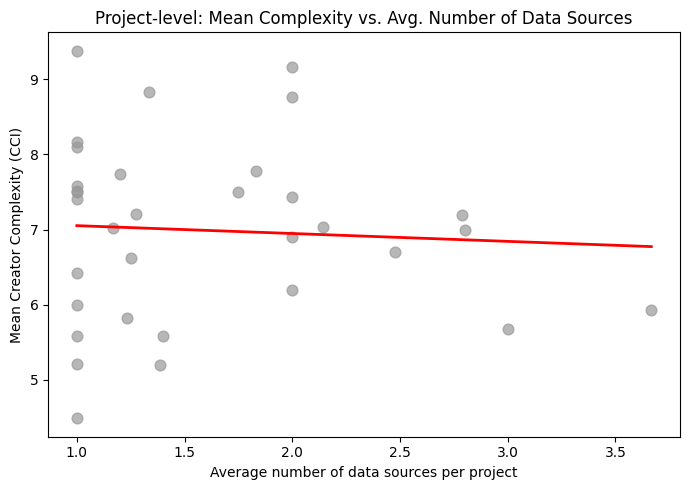

In [48]:
x_avg = projects["avg_n_data_sources"]
y_mean = projects["mean_creator_complexity"]
plt.figure(figsize=(7,5))

# Scatter
plt.scatter(x_avg, y_mean, alpha=0.7, s=60, color="#999999")

# Regression line
m, b = np.polyfit(x_avg, y_mean, 1)
x_line = np.linspace(x_avg.min(), x_avg.max(), 100)
plt.plot(x_line, m*x_line + b, linewidth=2, color="red")
plt.title("Project-level: Mean Complexity vs. Avg. Number of Data Sources")
plt.xlabel("Average number of data sources per project")
plt.ylabel("Mean Creator Complexity (CCI)")
plt.tight_layout()
plt.show()

In [49]:
# === Project-level correlations ===
x_proj = projects["avg_n_data_sources"]
y_proj = projects["mean_creator_complexity"]

pearson_proj, pearson_proj_p = pearsonr(x_proj, y_proj)
spearman_proj, spearman_proj_p = spearmanr(x_proj, y_proj)
kendall_proj, kendall_proj_p = kendalltau(x_proj, y_proj)

print("\n=== Project-level correlations ===")
print(f"Pearson r   = {pearson_proj:.3f} (p={pearson_proj_p})")
print(f"Spearman ρ  = {spearman_proj:.3f} (p={spearman_proj_p})")
print(f"Kendall τ   = {kendall_proj:.3f} (p={kendall_proj_p})")


=== Project-level correlations ===
Pearson r   = -0.063 (p=0.7296262163942048)
Spearman ρ  = -0.080 (p=0.6600036920081742)
Kendall τ   = -0.059 (p=0.6438709370081278)


## Data Sources per type

In [50]:
import pandas as pd

# Load your dataset
df = pd.read_csv("website_structure_with_interactions_derived.csv")

# --- CLEAN + COUNT DATA SOURCES PER CHART ---

# Ensure the column exists; adjust the name if needed
# Split multi–source strings like "Wikidata;IMDb" into lists
def split_sources(val):
    # Handle missing values
    if pd.isna(val):
        return []
    # Split on semicolon and remove extra spaces
    return [s.strip() for s in val.split(";") if s.strip()]

df["data_source_list"] = df["data_source"].apply(split_sources)

# Count how many sources each chart has
df["data_source_count"] = df["data_source_list"].apply(len)


# If you want the count *per chart*, not per row, group by chart_id
if "chart_id" in df.columns:
    source_counts = (
        df.groupby("chart_id")["data_source_list"]
        .apply(lambda lists: len(set(sum(lists, []))))  # unique sources per chart
        .reset_index()
        .rename(columns={"data_source_list": "data_source_count_chart"})
    )

    # Merge back into main DataFrame
    df = df.merge(source_counts, on="chart_id", how="left")

# Save the result
df.to_csv("processed_dataset.csv", index=False)


C:\Users\giuli\AppData\Local\Temp\ipykernel_21916\3206402304.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


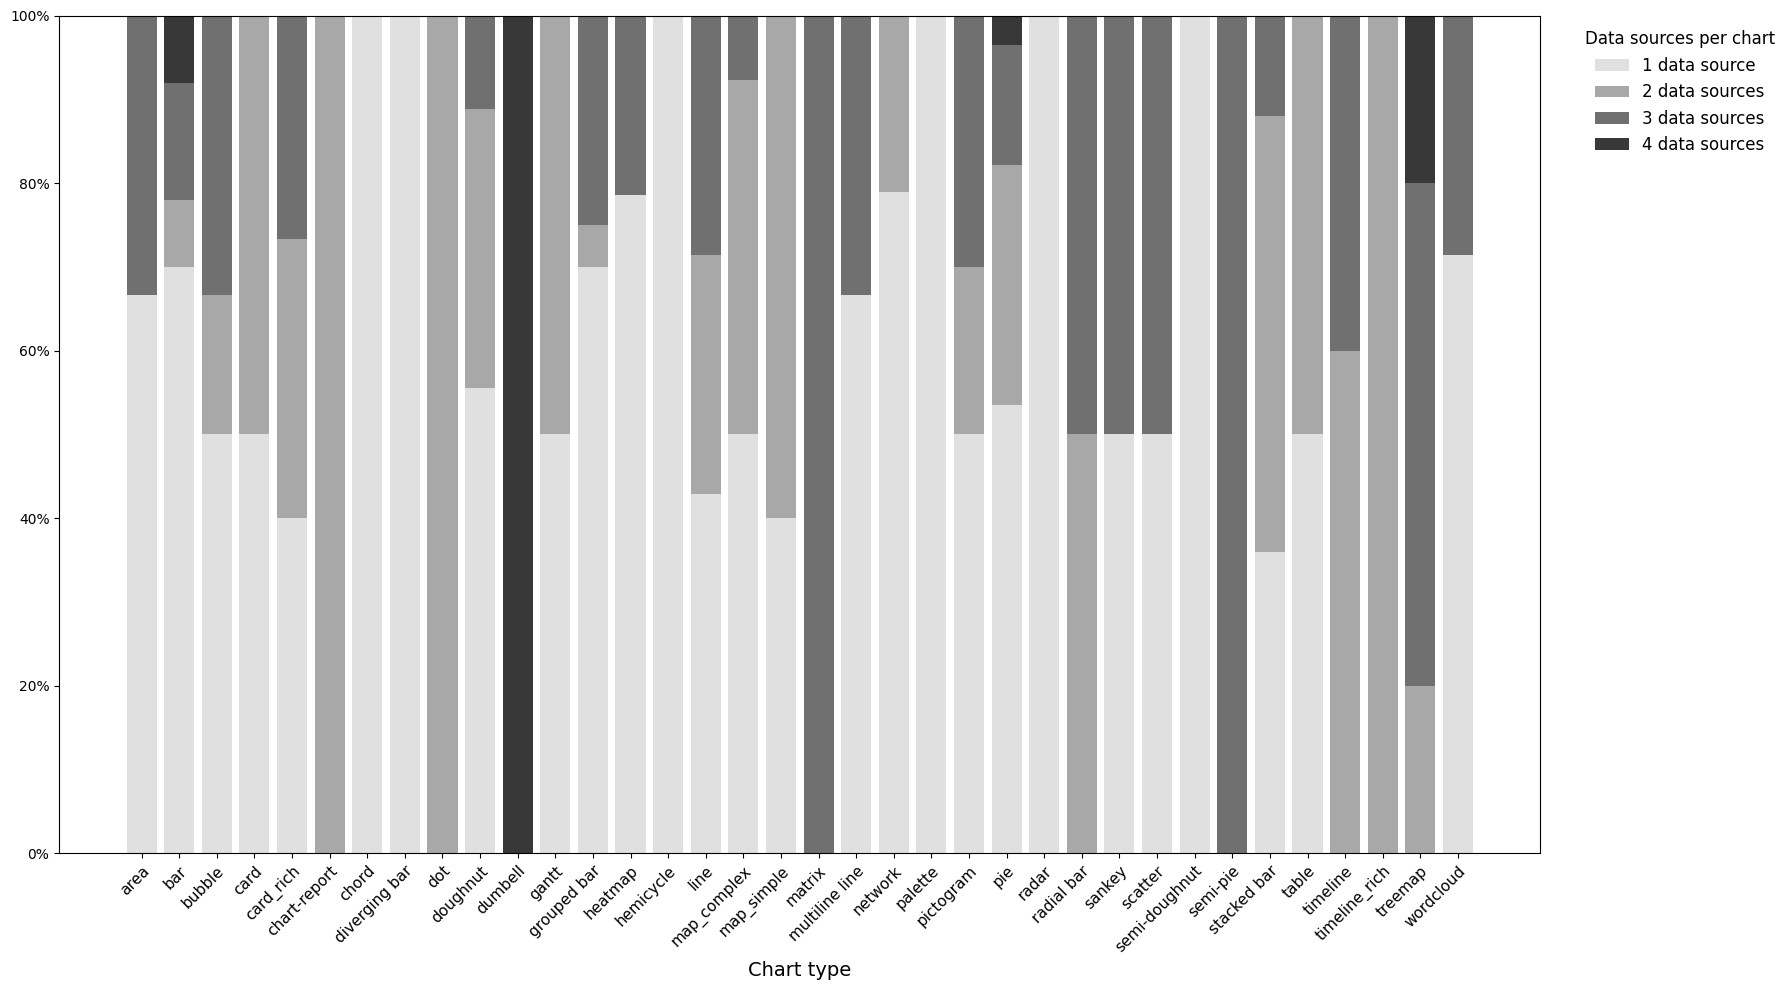

In [53]:
# Stacked vertical bar chart in grayscale (no black or white), scaled to percentages.
# - Reads the previously saved 'processed_dataset.csv' (must contain data_source_count)
# - Rebuilds the pivot table (chart_type x data_source_count)
# - Converts counts to percentages within each chart_type
# - Plots a vertical stacked bar chart where darker shades correspond to higher data_source_count

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# -----------------------------
# Load & aggregate
# -----------------------------
df = pd.read_csv("processed_dataset.csv")

# Keep only rows that correspond to charts (i.e., have a chart_type)
charts = df.dropna(subset=["chart_type_derived"]).copy()

# Count charts for each (chart_type, data_source_count)
agg = charts.groupby(["chart_type_derived", "data_source_count"]).size().reset_index(name="n_charts")

# Pivot to wide form for plotting
pivot = agg.pivot(index="chart_type_derived", columns="data_source_count", values="n_charts").fillna(0)

# -----------------------------
# Convert to percentages per chart_type
# -----------------------------
row_sums = pivot.sum(axis=1).replace(0, np.nan)  # avoid division by zero
pivot_pct = pivot.div(row_sums, axis=0).fillna(0)  # proportions in [0,1]

# Ensure columns (data_source_count) are sorted ascending so darker = higher
pivot_pct = pivot_pct.reindex(sorted(pivot_pct.columns), axis=1)

# -----------------------------
# Build grayscale palette (avoid white=1.0 and black=0.0)
# - Lightest gray ~ 0.88
# - Darkest gray ~ 0.22
# - Number of steps = number of data_source_count columns
# -----------------------------
n_levels = pivot_pct.shape[1]
# Generate grayscale values from light to dark
gray_values = np.linspace(0.88, 0.22, n_levels)
# Map each column to a gray shade (ascending count -> lighter; higher count -> darker)
colors = [str(g) for g in gray_values]  # matplotlib accepts grayscale strings like "0.5"

# --------------------------------
# Plot: vertical stacked bars (bigger + readable labels)
# --------------------------------

# Increase figure size so labels have room
fig, ax = plt.subplots(figsize=(18, 10))

bottom = np.zeros(len(pivot_pct), dtype=float)

# Plot each data_source_count as stacked vertical bar segments
for col, color in zip(pivot_pct.columns, colors):
    values = pivot_pct[col].values
    ax.bar(
        pivot_pct.index,
        values,
        bottom=bottom,
        label=f"{int(col)} data source" if int(col) == 1 else f"{int(col)} data sources",
        color=color,
        edgecolor="none"
    )
    bottom += values

# --------------------------------
# Style adjustments
# --------------------------------
ax.set_xlabel("Chart type", fontsize=14)

# Percentage formatting
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.set_ylim(0, 1)

# Rotate x labels and wrap long text
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,             # tilt them
    ha="right",              # align properly
    fontsize=11,             # make them readable
    wrap=True                # allow label wrapping
)

# Add some space below the labels
plt.subplots_adjust(bottom=0.3)

# Legend outside plot
ax.legend(
    title="Data sources per chart",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False,
    fontsize=12,
    title_fontsize=12
)

plt.tight_layout()
plt.show()


In [54]:
df = pd.read_csv("website_structure_with_interactions_derived.csv")

# ------------------------------------
# Keep only rows that are actual charts
# ------------------------------------
charts = df.dropna(subset=["chart_type_derived"]).copy()

# ------------------------------------
# Clean and split sources
# ------------------------------------
def clean_source_name(raw):
    s = str(raw).strip()
    return re.split(r"\(", s, maxsplit=1)[0].strip()

charts["sources_list"] = (
    charts["data_source"].fillna("").apply(
        lambda s: sorted({
            clean_source_name(x.strip())
            for x in str(s).split(";")
            if x.strip()
        })
    )
)

# ------------------------------------
# Explode to one row per (chart, source)
# ------------------------------------
df_long = (
    charts.explode("sources_list")
          .rename(columns={"sources_list": "source"})
          .dropna(subset=["source"])
)

# -----------------------------
# Count number of charts using each source per chart type
# -----------------------------
tmp = (
    df_long.groupby(["chart_type_derived", "source"])
           .size()
           .reset_index(name="n_charts")
)

tmp["pct_expanded"] = tmp["n_charts"] / tmp.groupby("chart_type_derived")["n_charts"].transform("sum") * 100

total_charts = charts["chart_type_derived"].value_counts().to_dict()

tmp["pct_unique"] = tmp.apply(
    lambda row: row["n_charts"] / total_charts[row["chart_type_derived"]] * 100,
    axis=1
)


tmp.head()

,chart_type_derived,source,n_charts,pct_expanded,pct_unique
0,area,ARTchives,1,10.0,16.666667
1,area,Amazon Prime,3,30.0,50.000000
2,area,Dictionary of Art Historians,1,10.0,16.666667
3,area,Netflix,3,30.0,50.000000
4,area,Wikidata,2,20.0,33.333333


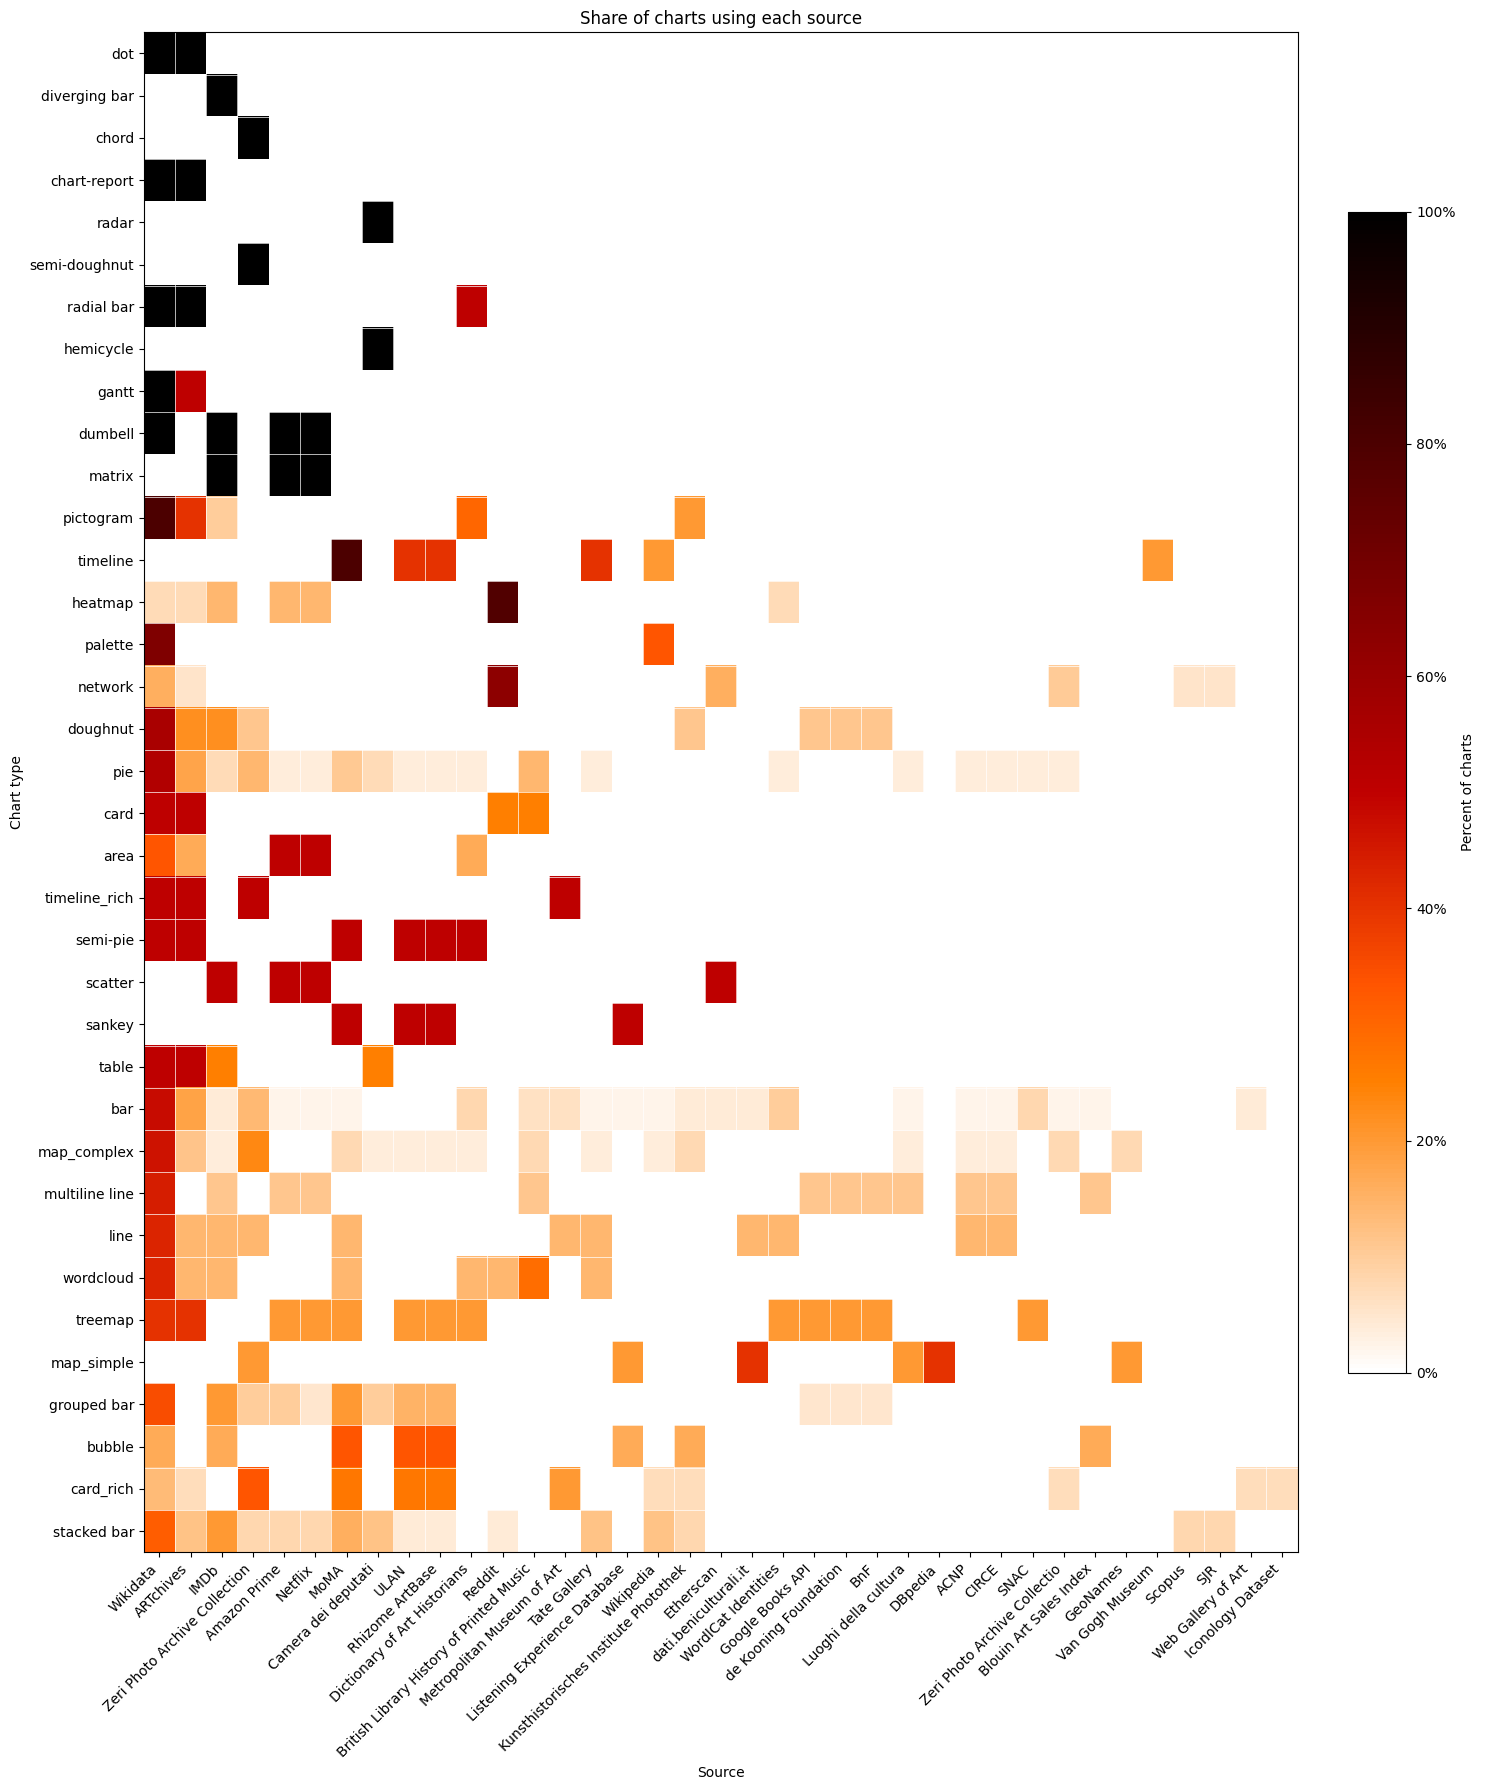

In [56]:
# ---------------------------------------------------
# 1) Pivot to matrix: rows=chart type, cols=source, vals=% of charts using source
# ---------------------------------------------------
heat = (
    tmp.pivot(index="chart_type_derived", columns="source", values="pct_unique")
       .fillna(0.0)                      # no usage -> 0%
)

# Order sources by overall prevalence across all chart types (descending)
col_order = heat.mean(axis=0).sort_values(ascending=False).index
heat = heat[col_order]

# Order chart types by their max % (descending) for a nicer structure
row_order = heat.max(axis=1).sort_values(ascending=False).index
heat = heat.loc[row_order]

# ---------------------------------------------------
# 2) Plot
# ---------------------------------------------------
# Figure size that scales with matrix size
h, w = heat.shape
fig_w = min(2 + 0.35 * w, 24)   # widen with #sources
fig_h = min(2 + 0.45 * h, 18)   # height with #chart types
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Show heatmap; values are percentages (0..100)
im = ax.imshow(heat.values, aspect="auto", cmap="gist_heat_r", vmin=0, vmax=100)

# Axis ticks & labels
ax.set_xticks(np.arange(w))
ax.set_yticks(np.arange(h))
ax.set_xticklabels(heat.columns, rotation=45, ha="right")
ax.set_yticklabels(heat.index)

# Gridlines for readability
ax.set_xticks(np.arange(-0.5, w, 1), minor=True)
ax.set_yticks(np.arange(-0.5, h, 1), minor=True)
ax.grid(which="minor", color="w", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_xlabel("Source")
ax.set_ylabel("Chart type")
ax.set_title("Share of charts using each source")

# Colorbar with percent formatter
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Percent of charts")
cbar.ax.yaxis.set_major_formatter(PercentFormatter(xmax=100.0))

plt.tight_layout()
plt.show()


## EDA/KD

In [58]:
# === Project-level EDA/KD classification (with normalization) ================

PATH_IN  = "website_structure_with_interactions_derived.csv"
PATH_OUT = "project_level_eda_kd.csv"

# -------------------- Load + light lowercase copies for filtering ------------
df = pd.read_csv(PATH_IN)
df["type_str"] = df["type"].astype(str).str.lower().str.strip()
df["role_str"] = df["role"].astype(str).str.lower().str.strip()
df["chart_title_type_str"] = df.get("chart_title_type", pd.Series(index=df.index)).astype(str).str.lower().str.strip()

is_chart = df["type_str"].str.contains("chart", na=False)
is_text  = df["type_str"].str.contains("text",  na=False)

# -------------------- Helpers -------------------------------------------------
def split_tokens(s):
    """Split feature strings into normalized tokens (lowercased)."""
    if not isinstance(s, str):
        return []
    return [t for t in re.split(r"[,\|\;]\s*|\s+", s.lower().strip()) if t]

def flexible_focus(features):
    """
    Focus flexibility:
      strong (2): filters, search, zoom, find-more, view-change
      weak   (1): hover, click, metadata, on-demand, flip, broken-y
      none   (0): else
    """
    toks = set(split_tokens(features))
    strong = {"filters", "filter", "search", "zoom", "find-more", "view-change"}
    weak   = {"hover", "click", "metadata", "on-demand", "flip", "broken-y"}
    if toks & strong: return 2
    if toks & weak:   return 1
    return 0

def interpretation_score(annotations):
    """Chart-level explanation via in-chart annotations."""
    return 1 if isinstance(annotations, str) and annotations.strip() else 0

def title_explanation_score(title_type_str):
    """Chart title framing: 'result' -> 1, else 0."""
    return 1 if isinstance(title_type_str, str) and title_type_str == "result" else 0

def multi_view_flag(rep):
    """Multiple related views → exploration boost."""
    return 1 if isinstance(rep, str) and rep.strip().lower() == "yes" else 0

def minmax(s: pd.Series) -> pd.Series:
    """Simple min–max normalization to [0,1]; returns zeros if constant."""
    smin, smax = s.min(), s.max()
    rng = smax - smin
    return (s - smin) / rng if rng else s*0

# -------------------- CHART-LEVEL: EDS and XPS components --------------------
charts = df[is_chart].copy()

# EDS components
charts["interaction_level_filled"] = charts["interaction_level"].fillna(0)
charts["flex_focus"] = charts["chart_interaction_feature"].apply(flexible_focus)
charts["multi_view"] = charts["repetition"].apply(multi_view_flag)
charts["EDS_chart"]  = charts["interaction_level_filled"] + charts["flex_focus"] + charts["multi_view"]

# XPS chart-level = annotations + result-oriented title (no sequence)
charts["interpretation"]    = charts["chart_annotations"].apply(interpretation_score)
charts["title_explanation"] = charts["chart_title_type_str"].apply(title_explanation_score)
charts["XPS_chart"]         = charts["interpretation"] + charts["title_explanation"]

# -------------------- TEXT-LEVEL: narrative flags per website ----------------
texts = df[is_text].copy()
summary_by_site    = texts.groupby("website", dropna=False)["role_str"].apply(lambda s: int((s == "summary").any()))
conclusion_by_site = texts.groupby("website", dropna=False)["role_str"].apply(lambda s: int((s == "conclusion").any()))

# -------------------- PROJECT-LEVEL aggregation ------------------------------
g = charts.groupby("website", dropna=False)

proj = pd.DataFrame({
    "n_charts":             g.size(),
    "EDS_mean":             g["EDS_chart"].mean(),
    "EDS_max":              g["EDS_chart"].max(),
    "interaction_max":      g["interaction_level_filled"].max(),
    "XPS_mean_from_charts": g["XPS_chart"].mean(),
    "any_annotation":       g["interpretation"].max(),
    "any_result_title":     g["title_explanation"].max(),
})

# attach narrative flags (from TEXT rows)
proj = proj.join(summary_by_site.rename("any_summary"), how="left")
proj = proj.join(conclusion_by_site.rename("any_conclusion"), how="left")
proj[["any_summary","any_conclusion"]] = proj[["any_summary","any_conclusion"]].fillna(0).astype(int)

# Compose raw project scores (keep these for reference/CSV)
proj["EDS_project"] = proj["EDS_mean"] + proj["interaction_max"]

SUMMARY_BONUS, CONCLUSION_BONUS = 2, 4  # moderate gap
proj["narrative_bonus"] = np.where(
    proj["any_conclusion"] == 1, CONCLUSION_BONUS,
    np.where(proj["any_summary"] == 1, SUMMARY_BONUS, 0)
)
proj["XPS_project"] = proj["XPS_mean_from_charts"] + proj["narrative_bonus"]

# -------------------- NORMALIZATION (project-level only) ---------------------
proj["EDS_norm"] = minmax(proj["EDS_project"])
proj["XPS_norm"] = minmax(proj["XPS_project"])

# Classify using normalized axes (balanced quadrants)
eds_thr = proj["EDS_norm"].median()
xps_thr = proj["XPS_norm"].median()

def classify_row(eds_n, xps_n, e_t, x_t):
    if eds_n >= e_t and xps_n <  x_t: return "EDA"
    if eds_n <  e_t and xps_n >= x_t: return "KD"
    if eds_n >= e_t and xps_n >= x_t: return "Hybrid"
    return "Descriptive"

proj["class_label"] = proj.apply(lambda r: classify_row(r["EDS_norm"], r["XPS_norm"], eds_thr, xps_thr), axis=1)

# -------------------- Save + quick peek --------------------------------------
cols = [
    # diagnostics / raw
    "n_charts",
    "EDS_mean","EDS_max","interaction_max","EDS_project",
    "XPS_mean_from_charts","narrative_bonus","XPS_project",
    "any_annotation","any_result_title","any_summary","any_conclusion",
    # normalized + class
    "EDS_norm","XPS_norm","class_label"
]
proj = proj[cols]
proj.to_csv(PATH_OUT, index=True, encoding="utf-8-sig")
print(f"Saved: {PATH_OUT}")
display(proj.head(10))



Saved: project_level_eda_kd.csv


,n_charts,EDS_mean,EDS_max,interaction_max,EDS_project,XPS_mean_from_charts,narrative_bonus,XPS_project,any_annotation,any_result_title,any_summary,any_conclusion,EDS_norm,XPS_norm,class_label
website,,,,,,,,,,,,,,,
https://ahsanv101.github.io/ProjectGaze/,13,1.153846,5,3,4.153846,0.153846,2,2.153846,1,0,1,0,0.511848,0.430769,Hybrid
https://alessandrafa.github.io/buerkel-photos/index.html,11,0.727273,4,2,2.727273,0.363636,4,4.363636,1,0,0,1,0.336062,0.872727,KD
https://alicebordignon.github.io/ITArtHistorians/index.html,14,1.571429,5,3,4.571429,0.142857,4,4.142857,1,0,0,1,0.563304,0.828571,Hybrid
https://alicepicco333.github.io/culture4all/,5,3.200000,4,2,5.200000,0.000000,4,4.000000,0,0,0,1,0.640758,0.800000,Hybrid
https://aschimmenti.github.io/humansOfZeriPhotoArchive,7,1.571429,4,3,4.571429,0.000000,2,2.000000,0,0,1,0,0.563304,0.400000,EDA
https://baizhankyzy.github.io/female-directors/,5,1.000000,4,2,3.000000,0.200000,4,4.200000,1,0,0,1,0.369668,0.840000,KD
https://dbrembilla.github.io/redditholes/,26,5.115385,6,3,8.115385,0.000000,4,4.000000,0,0,0,1,1.000000,0.800000,Hybrid
https://digitalstory33.github.io/RENAIScience/index.html,9,1.777778,6,3,4.777778,0.000000,0,0.000000,0,0,0,0,0.588731,0.000000,EDA
https://elisasilvad.github.io/the_journey_of_art/,12,1.833333,5,3,4.833333,0.416667,0,0.416667,1,1,0,0,0.595577,0.083333,EDA


In [59]:
# Ensure 'website' is the index on both frames
if proj.index.name != "website":
    proj = proj.copy()
    proj.index.name = "website"

meta = pd.read_csv("records.csv")

def count_sources_semicolon(s):
    """
    Count semicolon-separated data sources in a project-level field.
    Handles NaN, empty strings, irregular spacing, and trailing semicolons.
    """
    # Handle missing values
    if pd.isna(s):
        return 0

    # Convert to string and strip outer whitespace
    s = str(s).strip()

    # Empty string → zero sources
    if s == "":
        return 0

    # Split on semicolon
    parts = s.split(";")
    return len(parts)


# Count semicolon-separated sources per project
meta["n_sources_meta"] = meta["data_source"].apply(count_sources_semicolon)
meta = meta.set_index("website")

# --- Safest: assign by mapping (avoids join + overlapping columns) ----------
proj["n_sources"] = proj.index.map(meta["n_sources_meta"])




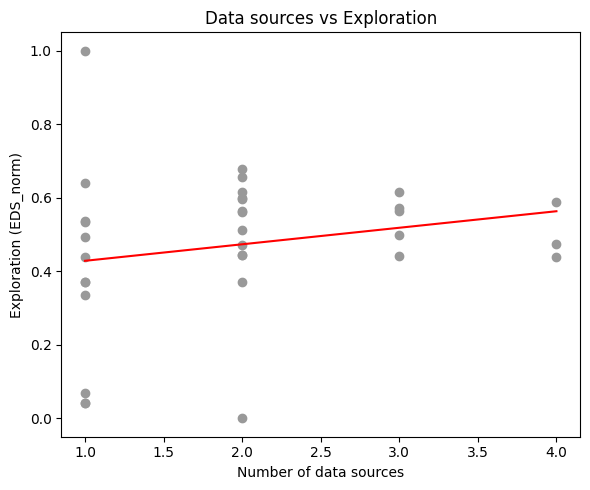

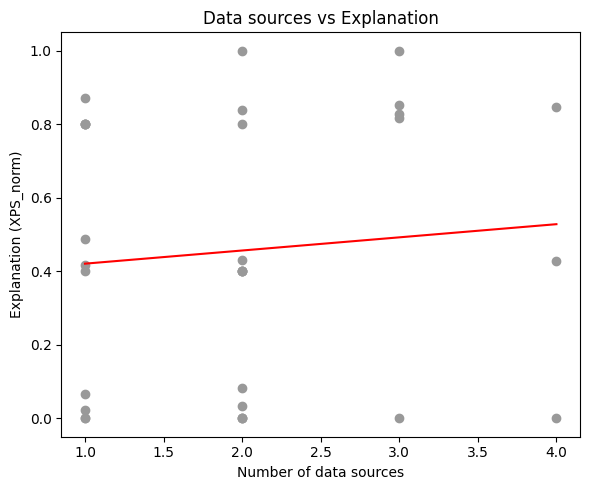

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(proj["n_sources"], proj["EDS_norm"], color="#999999")
m, b = np.polyfit(proj["n_sources"], proj["EDS_norm"], 1)
xx = np.linspace(proj["n_sources"].min(), proj["n_sources"].max(), 100)
plt.plot(xx, m*xx + b, color='red')
plt.xlabel("Number of data sources")
plt.ylabel("Exploration (EDS_norm)")
plt.title("Data sources vs Exploration")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(proj["n_sources"], proj["XPS_norm"], color="#999999")
m, b = np.polyfit(proj["n_sources"], proj["XPS_norm"], 1)
xx = np.linspace(proj["n_sources"].min(), proj["n_sources"].max(), 100)
plt.plot(xx, m*xx + b, color='red')
plt.xlabel("Number of data sources")
plt.ylabel("Explanation (XPS_norm)")
plt.title("Data sources vs Explanation")
plt.tight_layout()
plt.show()


In [61]:
from scipy.stats import pearsonr, spearmanr, kendalltau

# === EDS Project-level correlations ===
x_eds = proj["n_sources"]
y_eds = proj["EDS_norm"]

eds_pearson, eds_pearson_p = pearsonr(x_eds, y_eds)
eds_spearman, eds_spearman_p = spearmanr(x_eds, y_eds)
eds_kendall, eds_kendall_p = kendalltau(x_eds, y_eds)

print("=== EDS correlations ===")
print(f"Pearson r = {eds_pearson:.3f} (p={eds_pearson_p:.3f})")
print(f"Spearman ρ = {eds_spearman:.3f} (p={eds_spearman_p:.3f})")
print(f"Kendall τ = {eds_kendall:.3f} (p={eds_kendall_p:.3f})")


# === XPS Project-level correlations ===
x_xps = proj["n_sources"]
y_xps = proj["XPS_norm"]

xps_pearson, xps_pearson_p = pearsonr(x_xps, y_xps)
xps_spearman, xps_spearman_p = spearmanr(x_xps, y_xps)
xps_kendall, xps_kendall_p = kendalltau(x_xps, y_xps)

print("\n=== XPS correlations ===")
print(f"Pearson r   = {xps_pearson:.3f} (p={xps_pearson_p})")
print(f"Spearman ρ  = {xps_spearman:.3f} (p={xps_spearman_p})")
print(f"Kendall τ   = {xps_kendall:.3f} (p={xps_kendall_p})")




=== EDS correlations ===
Pearson r = 0.210 (p=0.241)
Spearman ρ = 0.270 (p=0.128)
Kendall τ = 0.193 (p=0.160)

=== XPS correlations ===
Pearson r   = 0.094 (p=0.6035044722955427)
Spearman ρ  = 0.129 (p=0.47446949092152524)
Kendall τ   = 0.092 (p=0.5157483745081886)


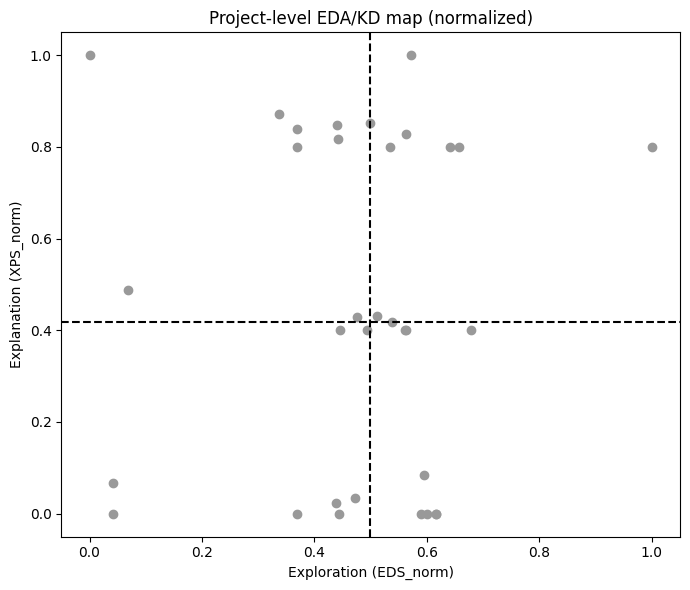

In [62]:
# -------------------- Optional scatter (normalized axes) ---------------------
plt.figure(figsize=(7,6))
plt.scatter(proj["EDS_norm"], proj["XPS_norm"], color="#999999")
plt.axvline(eds_thr, linestyle="--", color="black")
plt.axhline(xps_thr, linestyle="--", color="black")
plt.xlabel("Exploration (EDS_norm)")
plt.ylabel("Explanation (XPS_norm)")
plt.title("Project-level EDA/KD map (normalized)")
plt.tight_layout()
plt.show()